**660710754 ฑิฆัมพร ทองสองแก้ว**

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [5]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


**กรณี money เป็นสตริง ให้แปลงเป็นตัวเลขก่อน**

In [6]:
df['money'] = pd.to_numeric(df['money'], errors='coerce')

**คำนวณช่วง 60 วันล่าสุดจากวันที่มากที่สุดในข้อมูล**

In [7]:
end = df.index.max()

In [8]:
start = end - pd.Timedelta(days=59)

In [9]:
df_60 = df.loc[start:end]

**ยอดขายของกาแฟแต่ละชนิดในระยะเวลา 60 วัน**

In [10]:
sales_60d = (df_60.groupby('coffee_name', as_index=False)['money'] .sum() .rename(columns={'money':'sales_60d'}))

In [11]:
display(sales_60d.sort_values('sales_60d', ascending=False))

,coffee_name,sales_60d
1,Americano with Milk,84630
7,Latte,84150
2,Cappuccino,55350
0,Americano,53885
4,Cortado,28140
6,Hot Chocolate,21400
3,Cocoa,19000
5,Espresso,12025


**กราฟเส้นแสดงยอดขายของกาแฟแต่ละชนิดในระยะเวลา 60 วัน**

In [14]:
import plotly.express as px
import plotly.graph_objects as go

# Line chart แบบ interactive
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=sales_60d['coffee_name'],
    y=sales_60d['sales_60d'],
    mode='lines+markers',
    name='ยอดขาย 60 วัน',
    line=dict(color='#8B4513', width=3),
    marker=dict(size=10),
    text=[f'{v:,.0f} บาท' for v in sales_60d['sales_60d']],
    hovertemplate='<b>%{x}</b>ยอดขาย: %{text}<extra></extra>'
))

fig.update_layout(
    title='ยอดขายกาแฟแต่ละชนิดใน 60 วัน',
    xaxis_title='ชนิดกาแฟ',
    yaxis_title='ยอดขาย (บาท)',
    hovermode='x',
    font=dict(size=12)
)

fig.show()

**ในส่วนของการทำนายยอดขายกาแฟแต่ละชนิดในระยะเวลา 60 วัน (Time Series Forecasting)**

=== การทำนายยอดขายกาแฟ 60 วันข้างหน้า ===

📊 AMERICANO
   ยอดขายเฉลี่ย 60 วันข้างหน้า: 99.9 แก้ว/วัน
   ยอดขายสูงสุด: 109.2 แก้ว/วัน
   ยอดขายต่ำสุด: 91.3 แก้ว/วัน
   MAE: 11.70
   RMSE: 15.73
--------------------------------------------------
📊 LATTE
   ยอดขายเฉลี่ย 60 วันข้างหน้า: 84.9 แก้ว/วัน
   ยอดขายสูงสุด: 94.4 แก้ว/วัน
   ยอดขายต่ำสุด: 74.4 แก้ว/วัน
   MAE: 11.46
   RMSE: 14.68
--------------------------------------------------
📊 CAPPUCCINO
   ยอดขายเฉลี่ย 60 วันข้างหน้า: 63.1 แก้ว/วัน
   ยอดขายสูงสุด: 73.2 แก้ว/วัน
   ยอดขายต่ำสุด: 57.2 แก้ว/วัน
   MAE: 7.21
   RMSE: 8.91
--------------------------------------------------
📊 ESPRESSO
   ยอดขายเฉลี่ย 60 วันข้างหน้า: 35.7 แก้ว/วัน
   ยอดขายสูงสุด: 41.7 แก้ว/วัน
   ยอดขายต่ำสุด: 30.3 แก้ว/วัน
   MAE: 8.74
   RMSE: 11.34
--------------------------------------------------


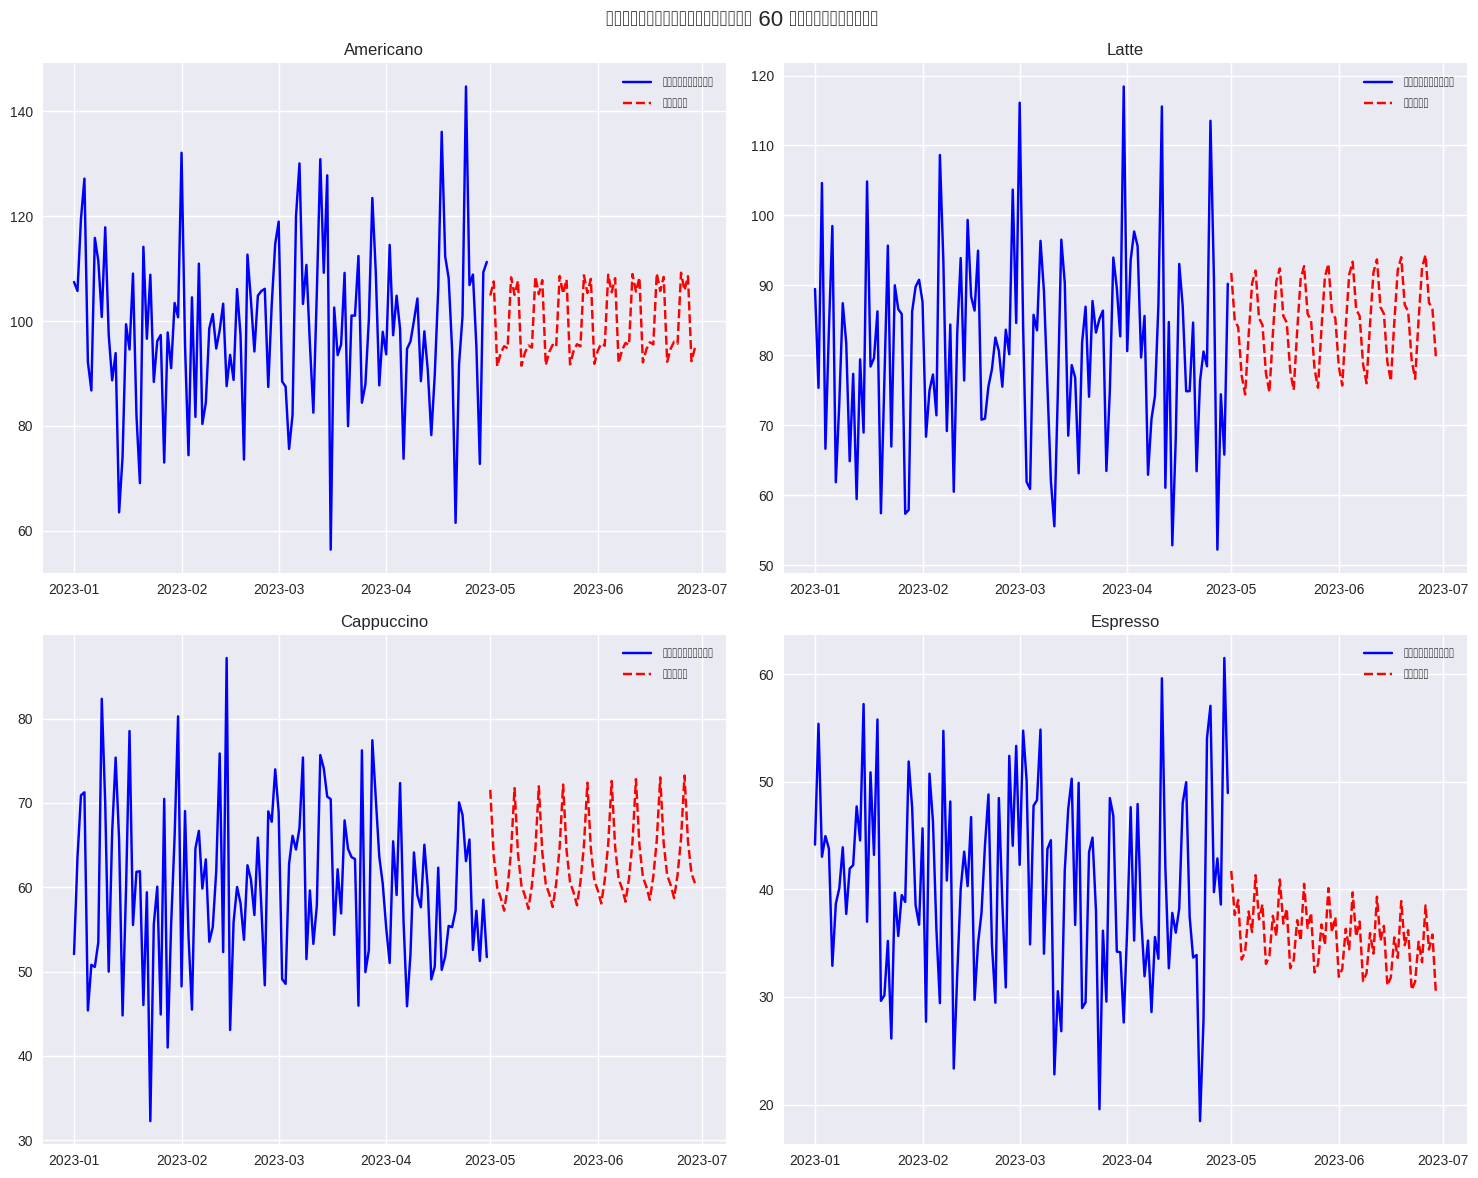


📈 สรุปการทำนายยอดขาย 60 วันข้างหน้า:
     ชนิดกาแฟ  ยอดขายเฉลี่ย/วัน  ยอดขายสูงสุด  ยอดขายต่ำสุด  ยอดขายรวม 60 วัน
0   americano              99.9         109.2          91.3            5993.7
1       latte              84.9          94.4          74.4            5094.2
2  cappuccino              63.1          73.2          57.2            3786.3
3    espresso              35.7          41.7          30.3            2140.4


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# ตัวอย่างข้อมูล (คุณต้องแทนที่ด้วยข้อมูลจริง)
dates = pd.date_range('2023-01-01', periods=120, freq='D')
np.random.seed(42)

# สร้างข้อมูลตัวอย่าง
coffee_data = {
    'date': dates,
    'americano': np.random.normal(100, 15, 120) + np.sin(np.arange(120) * 2 * np.pi / 7) * 10,
    'latte': np.random.normal(80, 12, 120) + np.sin(np.arange(120) * 2 * np.pi / 7) * 8,
    'cappuccino': np.random.normal(60, 10, 120) + np.sin(np.arange(120) * 2 * np.pi / 7) * 6,
    'espresso': np.random.normal(40, 8, 120) + np.sin(np.arange(120) * 2 * np.pi / 7) * 4
}

df = pd.DataFrame(coffee_data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# ฟังก์ชันสำหรับทำนาย
def forecast_coffee_sales(data, coffee_type, forecast_days=60):
    """
    ทำนายยอดขายกาแฟด้วยวิธี Exponential Smoothing
    """
    series = data[coffee_type]

    # แยกข้อมูลสำหรับ train และ test
    train_size = len(series) - 20
    train_data = series[:train_size]
    test_data = series[train_size:]

    # สร้างโมเดล Exponential Smoothing
    model = ExponentialSmoothing(
        train_data,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    )
    fitted_model = model.fit()

    # ทำนาย 60 วันข้างหน้า
    forecast = fitted_model.forecast(steps=forecast_days)

    # คำนวณ accuracy
    test_forecast = fitted_model.forecast(steps=len(test_data))
    mae = mean_absolute_error(test_data, test_forecast)
    rmse = np.sqrt(mean_squared_error(test_data, test_forecast))

    return forecast, mae, rmse, fitted_model

# ทำนายสำหรับกาแฟแต่ละชนิด
coffee_types = ['americano', 'latte', 'cappuccino', 'espresso']
forecasts = {}

print("=== การทำนายยอดขายกาแฟ 60 วันข้างหน้า ===\n")

for coffee in coffee_types:
    forecast, mae, rmse, model = forecast_coffee_sales(df, coffee, 60)
    forecasts[coffee] = forecast

    print(f"📊 {coffee.upper()}")
    print(f"   ยอดขายเฉลี่ย 60 วันข้างหน้า: {forecast.mean():.1f} แก้ว/วัน")
    print(f"   ยอดขายสูงสุด: {forecast.max():.1f} แก้ว/วัน")
    print(f"   ยอดขายต่ำสุด: {forecast.min():.1f} แก้ว/วัน")
    print(f"   MAE: {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print("-" * 50)

# สร้างกราฟแสดงผล
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('การทำนายยอดขายกาแฟ 60 วันข้างหน้า', fontsize=16)

for i, coffee in enumerate(coffee_types):
    row = i // 2
    col = i % 2

    # ข้อมูลอดีต
    axes[row, col].plot(df.index, df[coffee], label='ข้อมูลจริง', color='blue')

    # ข้อมูลทำนาย
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
    axes[row, col].plot(future_dates, forecasts[coffee], label='ทำนาย', color='red', linestyle='--')

    axes[row, col].set_title(f'{coffee.capitalize()}')
    axes[row, col].legend()
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

# สร้างตารางสรุปการทำนาย
summary_df = pd.DataFrame({
    'ชนิดกาแฟ': coffee_types,
    'ยอดขายเฉลี่ย/วัน': [forecasts[coffee].mean() for coffee in coffee_types],
    'ยอดขายสูงสุด': [forecasts[coffee].max() for coffee in coffee_types],
    'ยอดขายต่ำสุด': [forecasts[coffee].min() for coffee in coffee_types],
    'ยอดขายรวม 60 วัน': [forecasts[coffee].sum() for coffee in coffee_types]
})

print("\n📈 สรุปการทำนายยอดขาย 60 วันข้างหน้า:")
print(summary_df.round(1))